# Figure 1 Notebook
Originally written by Derek Bogdanoff, edited for portability/clarity by George Hartoularos

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import scanpy as sc
import scipy

Some housekeeping:

In [2]:
sc.settings.verbosity=4
sc.settings.set_figure_params(dpi=80)
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


_GH:_ Adding a prefix here. The idea is that raw data will need to be downloaded separately from a repository (e.g. GEO) and may be in a random location on a person's computer. By having a separate file that all the notebooks read in once, they only have to edit that document with the path to the folder and then, assuming they have not changed the structure of that directory, all the notebooks will work without having to change path names in every single one.

In [3]:
with open('../../path.to.data.txt', 'r') as file:
    prefix = file.readline().strip()

_GH:_ Next 3 cells are commented out because the data on box does not have a directory called `20190319_miSeq`. Instead, it's called `20190319_cell_line_exp` and it's already an h5ad.

In [4]:
# #designate working directory 
# #path should contain: matrix.mtx, plate_map.csv, cell_annotate.txt
# #for scanpy annotations: barcodes.tsv, genes.tsv
# #
# #

# path='/Users/derekbogdanoff/projects/XYZeq/data/20190319_miSeq/human_mouse_gene_count/'

# plate_map='../../../XYZeq/data/20181219_species_exp/plate23_map.csv'

In [5]:
# sc.settings.verbosity=3
# sc.settings.set_figure_params(dpi=80)
# sc.logging.print_versions()
# results_file = './write/results.h5ad'

# #sc.settings = True

# ##load the data
# adata=sc.read(path + 'matrix.mtx', cache=True).T


# ##name the genes
# adata.var_names = [gene.strip() for gene in open(path + 'genes2.tsv', 'r')]


# ##name the cells
# adata.obs_names = [barcode.strip() for barcode in open(path + 'barcodes.tsv', 'r')] 




In [6]:
# adata.var_names_make_unique()

_GH:_ Instead, loading in the h5ad. @Derek should upload the original files to Box if we'd like to convert them here. Otherwise can just provide the h5ad to the community.

## Load Matrix and Filter

In [3]:
#adata = sc.read_h5ad(prefix + 'old_directories/20190319_cell_line_exp/20190319_cell_line.h5ad')

adata = sc.read_h5ad('/Users/derekbogdanoff/projects/XYZeq/cell_line.h5ad')

In [4]:
##post processing filter minimum UMIS and genes
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_cells(adata, min_genes=100)

sc.pp.filter_cells(adata, max_counts=10000)


##post processing filter genes 
  

## define mito genes 
mito_genes=[name for name in adata.var_names if name.startswith(('mm10_mt-', 'hg19_mt-', 'mt-'))]


##create new obs anotation to define percent mito for each cell 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)*100

##create new obs anotation to define UMIs per cell
adata.obs['n_counts'] = adata.X.sum(axis=1)

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [5]:
##filter based on mitochondrial content
adata = adata[adata.obs['percent_mito'] < 1, :]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [6]:
##plot cells per well
well_counts = adata.obs.groupby('barcode').size()

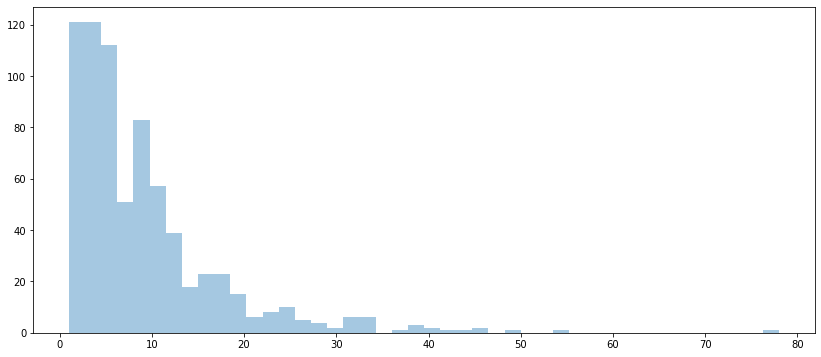

In [7]:
plt.rcParams['figure.figsize'] = [14, 6]

sns.distplot(well_counts,
             kde=False
            )

plt.grid(False)

In [13]:
adata

View of AnnData object with n_obs × n_vars = 6510 × 31708
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'n_cells'

## Make Barnyard

In [9]:
mouse_genes=[name for name in adata.var_names if name.startswith('mm10_')]
human_genes=[name for name in adata.var_names if name.startswith('hg19_')]

adata.obs['mouse_counts'] = np.sum(adata[:, mouse_genes].X, axis=1)
adata.obs['human_counts'] = np.sum(adata[:, human_genes].X, axis=1)

Trying to set attribute `.obs` of view, copying.
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [10]:
cmap = mpl.colors.ListedColormap(['royalblue','lightgrey', 'orangered'])

In [11]:
np.seterr(divide = 'ignore') 
adata.obs['ratio'] = np.log10(np.true_divide(adata.obs['mouse_counts'], adata.obs['human_counts']))

def cell_call(counts):
    if counts['ratio'] > 0.66:
        return 'M'
    elif counts['ratio'] < -0.66:
        return 'H'
    else:
        return 'C'

adata.obs['cell_call']=adata.obs.apply(lambda counts: cell_call(counts), axis=1)

### Figure 1D:

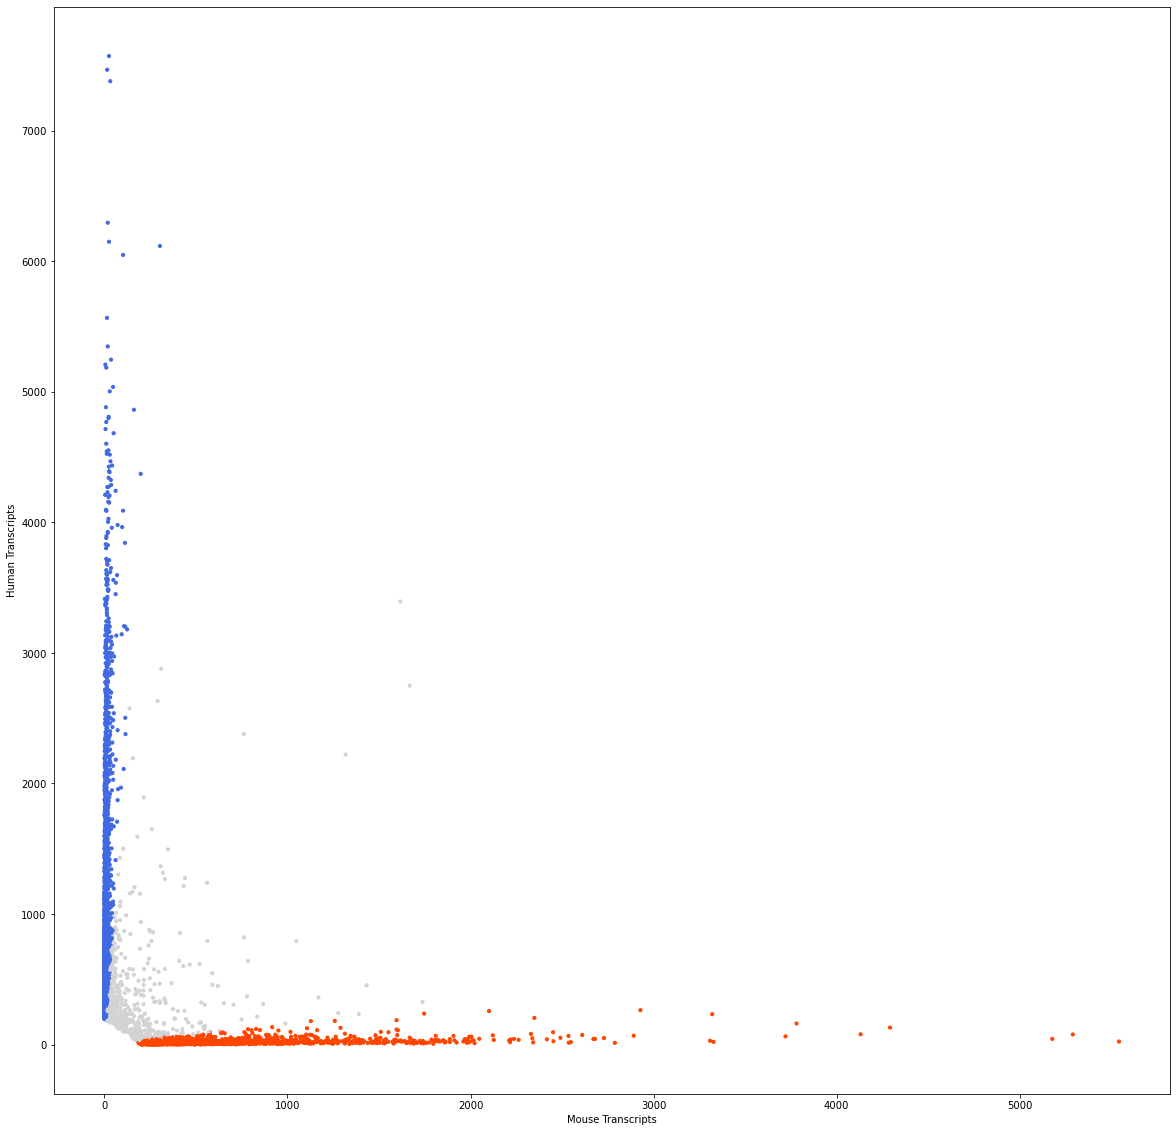

In [13]:
plt.figure(figsize=(20, 20))

plt.scatter(x=adata.obs['mouse_counts'], 
            y=adata.obs['human_counts'],
            s=10,
            c=adata.obs['ratio'],
           cmap=cmap)

plt.xlabel('Mouse Transcripts')
plt.ylabel('Human Transcripts')
plt.grid(b=False)

In [14]:
adata.obs['cell_call'].value_counts()

H    4442
M    1736
C     332
Name: cell_call, dtype: int64

In [15]:
adata.obs['cell_call'].value_counts(normalize=True)

H    0.682335
M    0.266667
C    0.050998
Name: cell_call, dtype: float64

In [16]:
#multiply mixed species by 2 to account for doublets of same species
adata.obs['cell_call'].value_counts(normalize=True)['C']*2

0.10199692780337942

## Violin Plots

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


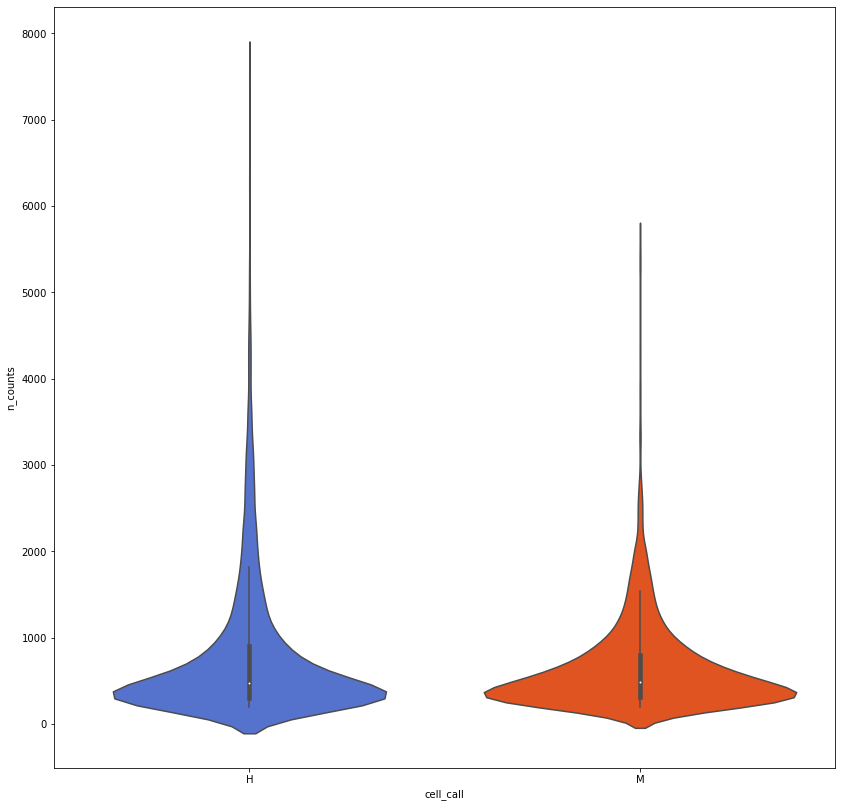

In [17]:
plt.rcParams['figure.figsize'] = [14, 14]

sns.violinplot(data=adata[adata.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_counts',
               palette=['royalblue', 'orangered']
              );

#plt.axis('off')
plt.grid(False)

In [18]:
print("median UMIs mouse: " + str(np.median(adata[adata.obs['cell_call']=='M'].obs.n_counts)))

print("median UMIs human: " + str(np.median(adata[adata.obs['cell_call']=='H'].obs.n_counts)))



median UMIs mouse: 489.5
median UMIs human: 480.5


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


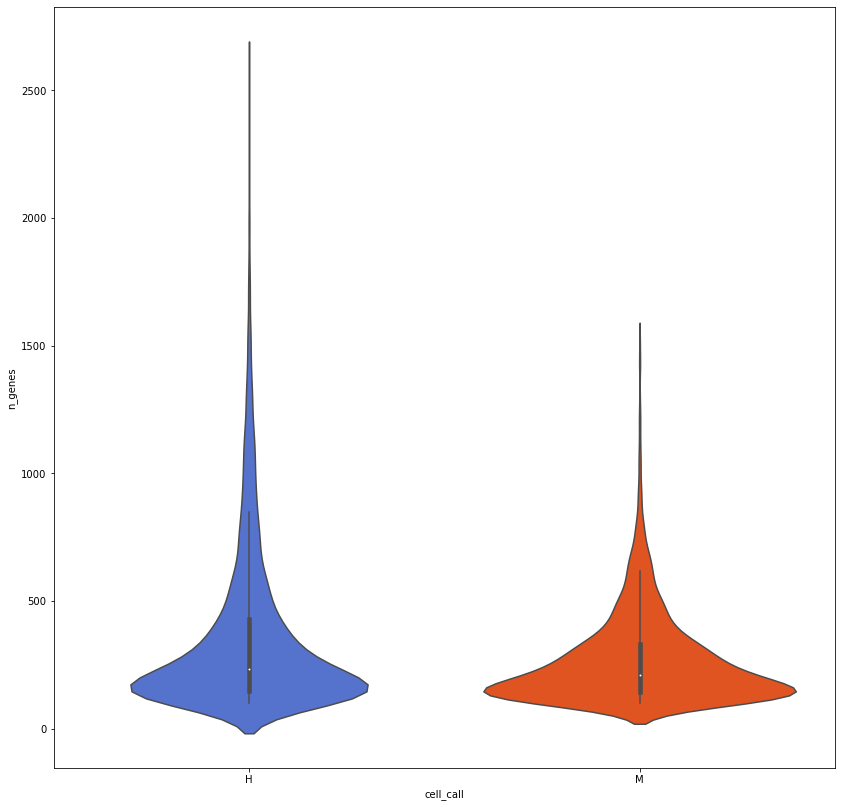

In [19]:
plt.rcParams['figure.figsize'] = [14, 14]

sns.violinplot(data=adata[adata.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_genes',
               palette=['royalblue', 'orangered']
              )

#plt.axis('off')
plt.grid(False) 

In [20]:
print("median genes mouse: " + str(np.median(adata[adata.obs['cell_call']=='M'].obs.n_genes)))

print("median genes human: " + str(np.median(adata[adata.obs['cell_call']=='H'].obs.n_genes)))



median genes mouse: 209.5
median genes human: 234.0


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## Column Graphs Across Array

In [21]:
##read barcode map and attach coordinates to adata


plate_map = "/Users/derekbogdanoff/projects/XYZeq/plate23_map.csv"

spatial_map=pd.read_csv(plate_map,
                        header=None,
                        names=['barcode', 'X', 'Y']
                       )

adata.obs = adata.obs.reset_index().merge(spatial_map, on='barcode',how='left').set_index('index')




In [22]:
df = adata.obs.groupby('X')['cell_call'].value_counts(['']).unstack()
df.columns.name='Cell Species'
df=df[['M','H','C']]

In [23]:
barplot_cmap=mpl.colors.ListedColormap(['orangered','royalblue','lightgrey'])

### Figure 1E:

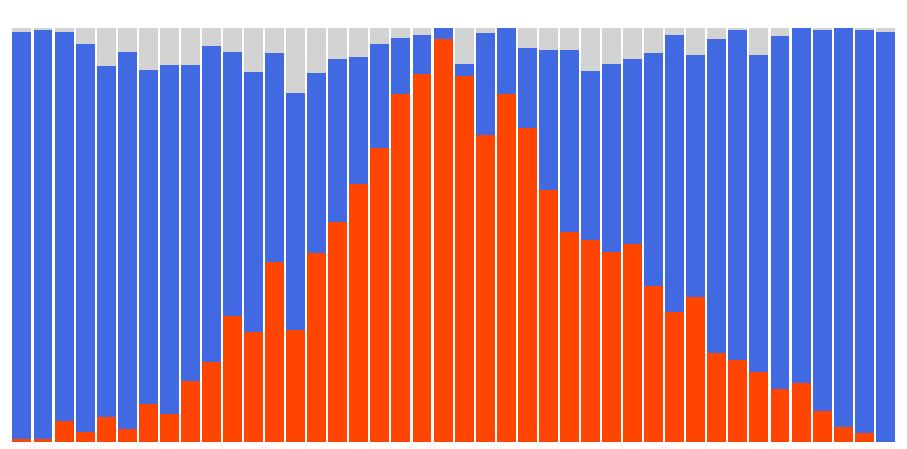

In [24]:
plt.rcParams['figure.figsize'] = [16, 8]


df.plot.bar(stacked=True,
                width=0.9, 
                cmap=barplot_cmap, 
                ecolor='white',
              # alpha=.6,
                legend=None
               )


plt.axis('off')
plt.grid(False)              